In [ ]:
from google.colab import drive
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.callbacks import ModelCheckpointZ
from tensorflow.keras.models import load_model

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_dir = '/content/drive/MyDrive/nuclei/images/'
print(len(os.listdir(image_dir)))

FileNotFoundError: ignored

In [ ]:
imgs = []
for fn in sorted(os.listdir(image_dir)):
  print(fn)
  im = cv2.imread(image_dir + fn)
  blue, green, red = cv2.split(im)
  #im = cv2.resize(red,(128, 128))
  im = red
  imgs.append(im)

#plt.imshow(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB))
plt.imshow(imgs[0], cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

FileNotFoundError: ignored

In [ ]:
mask_dir = '/content/drive/MyDrive/nuclei/mask/'
print(len(os.listdir(image_dir)))

5000


Streaming output truncated to the last 5000 lines.
000007.png
000008.png
000009.png
000010.png
000011.png
000012.png
000013.png
000014.png
000015.png
000016.png
000017.png
000018.png
000019.png
000020.png
000021.png
000022.png
000023.png
000024.png
000025.png
000026.png
000027.png
000028.png
000029.png
000030.png
000031.png
000032.png
000033.png
000034.png
000035.png
000036.png
000037.png
000038.png
000039.png
000040.png
000041.png
000042.png
000043.png
000044.png
000045.png
000046.png
000047.png
000048.png
000049.png
000050.png
000051.png
000052.png
000053.png
000054.png
000055.png
000056.png
000057.png
000058.png
000059.png
000060.png
000061.png
000062.png
000063.png
000064.png
000065.png
000066.png
000067.png
000068.png
000069.png
000070.png
000071.png
000072.png
000073.png
000074.png
000075.png
000076.png
000077.png
000078.png
000079.png
000080.png
000081.png
000082.png
000083.png
000084.png
000085.png
000086.png
000087.png
000088.png
000089.png
000090.png
000091.png
000092.png
000

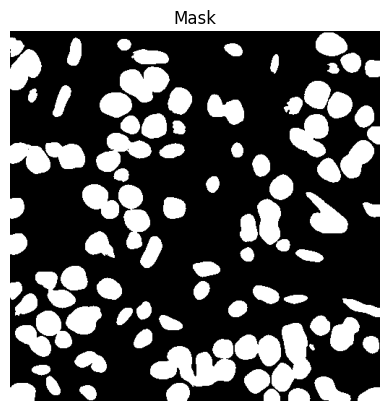

In [ ]:
masks = []
for fn in sorted(os.listdir(mask_dir)):
  print(fn)
  temp = cv2.imread(mask_dir + fn)
  grayscale_image = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
  # grayscale_image = cv2.resize(grayscale_image,(128, 128))
  grayscale_image[grayscale_image > 0] = 1
  masks.append(grayscale_image)

print(masks[0])
plt.imshow(masks[0], cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.show()

In [ ]:
train_imgs, test_imgs = imgs[:4000], imgs[4000:]
train_masks, test_masks = masks[:4000], masks[4000:]

train_imgs = np.array(train_imgs)
test_imgs = np.array(test_imgs)

train_masks = np.array(train_masks)
test_masks = np.array(test_masks)

train_imgs = train_imgs/255.0
test_imgs = test_imgs/255.0

print(train_imgs.shape)
print(test_imgs.shape)
print(train_masks.shape)
print(test_masks.shape)

(4000, 512, 512)
(1000, 512, 512)
(4000, 512, 512)
(1000, 512, 512)


In [ ]:
class UNET:
    def __init__(self, inp_shape=(512, 512, 1)):
        # parameters that were reused on every convolution
        C2D_params = {
            'kernel_size': (3, 3),
            'activation': 'relu',
            'kernel_initializer': 'he_normal',
            'padding': 'same'
        }

        trans_params = {
            'kernel_size': (2, 2),
            'strides': (2, 2),
            'padding': 'same'
        }

        # initialization
        inputs = tf.keras.layers.Input(inp_shape)

        # encoder
        c1 = Conv2D(16, **C2D_params)(inputs)
        c1 = Dropout(0.1)(c1)
        c1 = Conv2D(16, **C2D_params)(c1)
        p1 = MaxPooling2D((2, 2))(c1)

        c2 = Conv2D(32, **C2D_params)(p1)
        c2 = Dropout(0.1)(c2)
        c2 = Conv2D(32, **C2D_params)(c2)
        p2 = MaxPooling2D((2, 2))(c2)

        c3 = Conv2D(64, **C2D_params)(p2)
        c3 = Dropout(0.2)(c3)
        c3 = Conv2D(64, **C2D_params)(c3)
        p3 = MaxPooling2D((2, 2))(c3)

        c4 = Conv2D(128, **C2D_params)(p3)
        c4 = Dropout(0.2)(c4)
        c4 = Conv2D(128, **C2D_params)(c4)
        p4 = MaxPooling2D((2, 2))(c4)

        # valley
        c5 = Conv2D(256, **C2D_params)(p4)
        c5 = Dropout(0.3)(c5)
        c5 = Conv2D(256, **C2D_params)(c5)

        # decoder
        u6 = Conv2DTranspose(128, **trans_params)(c5)
        u6 = concat([u6, c4])
        c6 = Conv2D(128, **C2D_params)(u6)
        c6 = Dropout(0.2)(c6)
        c6 = Conv2D(128, **C2D_params)(c6)

        u7 = Conv2DTranspose(64, **trans_params)(c6)
        u7 = concat([u7, c3])
        c7 = Conv2D(64, **C2D_params)(u7)
        c7 = Dropout(0.2)(c7)
        c7 = Conv2D(64, **C2D_params)(c7)

        u8 = Conv2DTranspose(32, **trans_params)(c7)
        u8 = concat([u8, c2])
        c8 = Conv2D(32, **C2D_params)(u8)
        c8 = Dropout(0.1)(c8)
        c8 = Conv2D(32, **C2D_params)(c8)

        u9 = Conv2DTranspose(16, **trans_params)(c8)
        u9 = concat([u9, c1], axis=3)
        c9 = Conv2D(16, **C2D_params)(u9)
        c9 = Dropout(0.1)(c9)
        c9 = Conv2D(16, **C2D_params)(c9)

        # unet output
        out = Conv2D(1, (1, 1), activation='sigmoid')(c9)

        # compile our unet
        unet = tf.keras.Model(inputs=[inputs], outputs=[out])
        unet.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=
             [
                'accuracy',
                tf.keras.metrics.AUC(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.Precision()
             ]
        )

        self.model = unet

In [ ]:
unet = UNET()
unet.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 512, 512, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [ ]:
filepath = "/content/drive/MyDrive/nuclei/epochs/nuclei-epoch-{epoch:02d}.hdf5"

cb = [
    ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max', save_freq='epoch')
]

preds = unet.model.fit(train_imgs, train_masks, validation_split=0.1, batch_size=16, epochs=50, callbacks=[cb])

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.8952 - auc: 0.9415 - recall: 0.5679 - precision: 0.7972
Epoch 1: saving model to /content/drive/MyDrive/nuclei/epochs/nuclei-epoch-01.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 [==============================] - 200s 762ms/step - loss: 0.2333 - accuracy: 0.8952 - auc: 0.9415 - recall: 0.5679 - precision: 0.7972 - val_loss: 0.1558 - val_accuracy: 0.9409 - val_auc: 0.9792 - val_recall: 0.8170 - val_precision: 0.8467
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.9584 - auc: 0.9894 - recall: 0.8842 - precision: 0.8865
Epoch 2: saving model to /content/drive/MyDrive/nuclei/epochs/nuclei-epoch-02.hdf5
225/225 [==============================] - 179s 795ms/step - loss: 0.0989 - accuracy: 0.9584 - auc: 0.9894 - recall: 0.8842 - precision: 0.8865 - val_loss: 0.0787 - val_accuracy: 0.9676 - val_auc: 0.9942 - val_recall: 0.9251 - val_precision: 0.8970
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9704 - auc: 0.9947 - recall: 0.9194 - precision: 0.9178
Epoch 3: saving model to /content/drive/MyDrive/nuclei/epochs/nuclei-epoch-03.hdf5
225/225 [==============================] -

In [ ]:
unet.model.save('/content/drive/MyDrive/nuclei/nuclei_final.h5')

In [ ]:
unet.model.history.history
keys = list(unet.model.history.history.keys())
keys

['loss',
 'accuracy',
 'auc',
 'recall',
 'precision',
 'val_loss',
 'val_accuracy',
 'val_auc',
 'val_recall',
 'val_precision']

In [ ]:
train_loss = unet.model.history.history[keys[0]]
print(keys[0])

val_loss = unet.model.history.history[keys[5]]
print(keys[5])

train_accuracy = unet.model.history.history[keys[1]]
print(keys[1])

val_accuracy = unet.model.history.history[keys[6]]
print(keys[6])

train_auc = unet.model.history.history[keys[2]]
print(keys[2])

val_auc = unet.model.history.history[keys[7]]
print(keys[7])

train_precision = unet.model.history.history[keys[3]]
print(keys[3])

val_precision = unet.model.history.history[keys[8]]
print(keys[8])

train_recall = unet.model.history.history[keys[4]]
print(keys[4])

val_recall = unet.model.history.history[keys[9]]
print(keys[9])

epochs = range(1, len(train_loss) + 1)

loss
val_loss
accuracy
val_accuracy
auc
val_auc
recall
val_recall
precision
val_precision


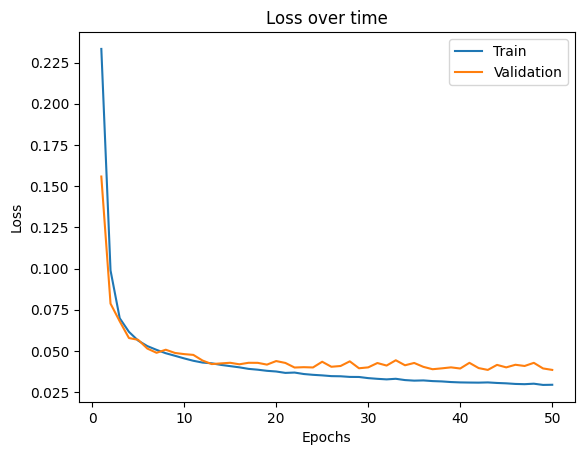

In [ ]:
plt.plot(epochs, train_loss, label='Train')
plt.plot(epochs, val_loss, label='Validation')
plt.title('Loss over time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/nuclei/plots/loss.png')
plt.show()

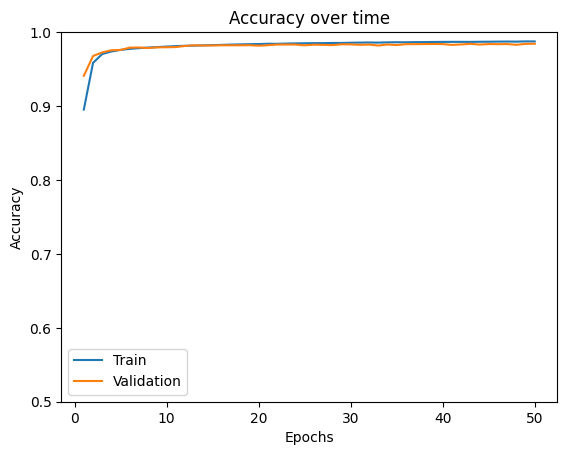

In [ ]:
plt.plot(epochs, train_accuracy, label='Train')
plt.plot(epochs, val_accuracy, label='Validation')
plt.title('Accuracy over time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/nuclei/plots/accuracy.png')
plt.ylim(0.5, 1)
plt.show()

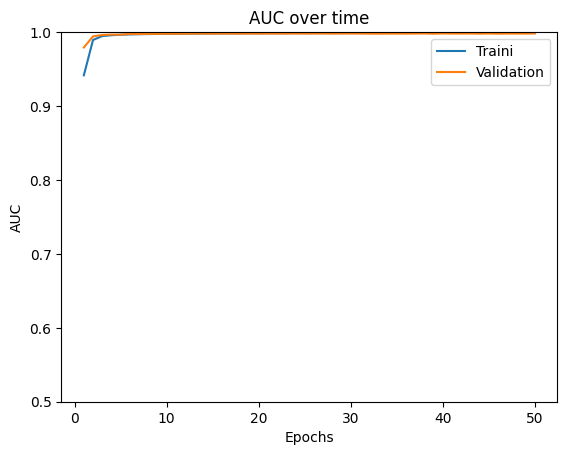

In [ ]:
plt.plot(epochs, train_auc, label='Traini')
plt.plot(epochs, val_auc, label='Validation')
plt.title('AUC over time')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.savefig('/content/drive/MyDrive/nuclei/plots/auc.png')
plt.ylim(0.5, 1)
plt.show()

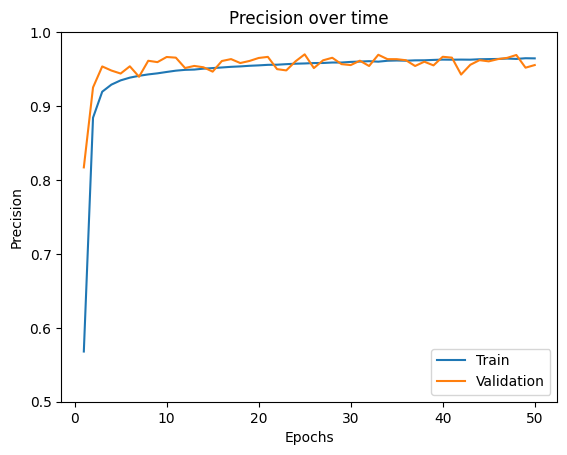

In [ ]:
plt.plot(epochs, train_precision, label='Train')
plt.plot(epochs, val_precision, label='Validation')
plt.title('Precision over time')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.savefig('/content/drive/MyDrive/nuclei/plots/precision.png')
plt.ylim(0.5, 1)
plt.show()

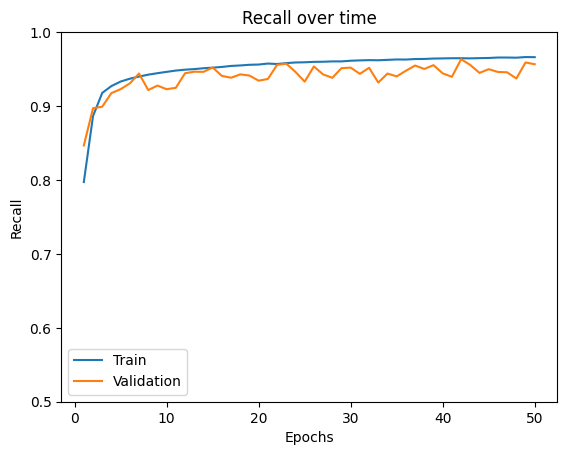

In [ ]:
plt.plot(epochs, train_recall, label='Train')
plt.plot(epochs, val_recall, label='Validation')
plt.title('Recall over time')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.savefig('/content/drive/MyDrive/nuclei/plots/recall.png')
plt.ylim(0.5, 1)
plt.show()

In [ ]:
preds = unet.model.predict(test_imgs)

32/32 [==============================] - 18s 333ms/step


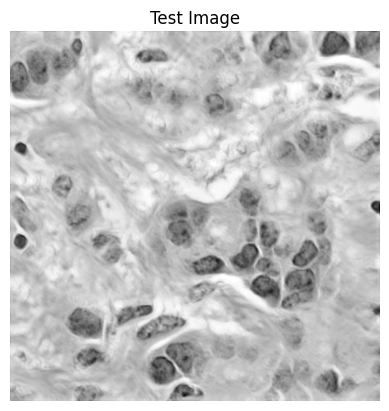

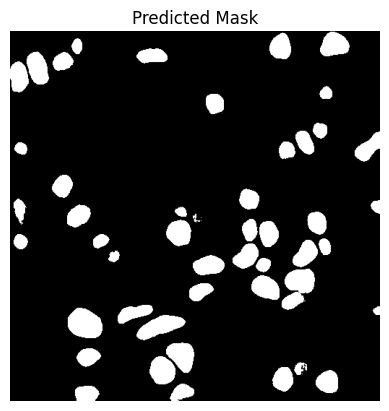

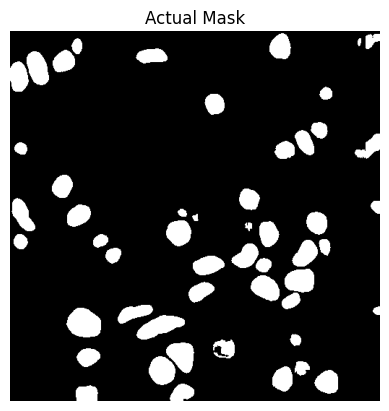

In [ ]:
img_to_test = 10

plt.imshow(test_imgs[img_to_test], cmap='gray')
plt.title('Test Image')
plt.axis('off')
plt.show()

test_preds = preds.copy()

new_preds = []
for i in range(len(test_preds)):
  temp = cv2.convertScaleAbs(test_preds[i])
  _, temp = cv2.threshold(temp, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  new_preds.append(temp)

plt.imshow(new_preds[img_to_test], cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')
plt.show()

plt.imshow(test_masks[img_to_test], cmap='gray')
plt.title('Actual Mask')
plt.axis('off')
plt.show()

In [ ]:
loss, accuracy, auc, precision, recall = unet.model.evaluate(test_imgs, test_masks, verbose=2)